Project code



In [347]:
import requests
from bs4 import BeautifulSoup
import pandas as pd



url = 'https://www.uksport.gov.uk/our-work/investing-in-sport/historical-funding-figures'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the first line to then copy after
heading = soup.find('h3', string="Summer Olympic Sports")

# Get the table after the heading
table = heading.find_next('table') 

rows = table.find_all('tr')

# Append and then into pd dataframe

funding = []
for row in rows:
    cells = row.find_all(['th', 'td'])
    values = [cell.get_text(strip=True) for cell in cells]
    if values: 
        funding.append(values)

funding_df = pd.DataFrame(funding[1:], columns=funding[0])

#Clean data to remove '£' ',' and convert '-' to NA

cols = ['London', 'Rio', 'Tokyo**', 'Paris*']


for col in cols:
    funding_df[col] = (
        funding_df[col]
        .replace('-', pd.NA)  # Replace '-' with pd.NA
        .str.replace('£', '', regex=False)  # Remove £
        .str.replace(',', '', regex=False)  # Remove commas
    )

    # Handle missing values before converting to float
    #funding_df[col] = funding_df[col].astype(int, errors='ignore')  # Convert to float

funding_df


,Sport,London,Rio,Tokyo**,Paris*
0,Archery,3479900,2473437,1122879,2632674
1,Artistic Swimming,2686800,1011290,251000,467250
2,Athletics,20613100,21820808,22416808,22175520
3,Badminton,5979860,4922229,889793,3322558
4,Baseball,<NA>,<NA>,30500,176250
5,Basketball,7127800,1927061,330500,1350000
6,Boxing,7551900,11151737,11606057,11597507
7,Breaking,<NA>,<NA>,<NA>,135000
8,Canoeing,12981800,16293651,15765693,13081836
9,Cycling,20613900,23966916,24559306,29172590


In [348]:
# get data from csv
# funding data is provide for the upcoming cycle eg funding for paris 2024 is decided 2021
inflation_df = pd.read_csv("InflationData.csv")
inflation_df = inflation_df.loc[26:42] # select relevant years for inflation


# Convert itno float to be useable
inflation_df['CPIH ANNUAL RATE 00: ALL ITEMS 2015=100'] = inflation_df['CPIH ANNUAL RATE 00: ALL ITEMS 2015=100'].astype(float)
inflation_df['Year'] = inflation_df['Title'].astype(int)
# Set intial inflation multiplier to 100
inflation_df.loc[inflation_df['Title'] == '2008', 'Base 2008 Millions'] = int(funding_df.iloc[34,1].replace('£', '').replace(',', '').strip())



# Cumulative inflation effect
for i in range(2009, 2025):
    prev_multiplier = inflation_df.loc[inflation_df['Year'] == i-1, 'Base 2008 Millions'].values[0]
    curr_inflation = inflation_df.loc[inflation_df['Year'] == i, 'CPIH ANNUAL RATE 00: ALL ITEMS 2015=100'].values[0]
    inflation_df.loc[inflation_df['Year'] == i, 'Base 2008 Millions'] = (prev_multiplier * (1 + curr_inflation / 100))
    

for i in range(2008, 2025):                 
    inflation_df.loc[inflation_df['Year'] == i, 'Multiplier'] = inflation_df.loc[inflation_df['Year'] == i, 'Base 2008 Millions'].values[0]/int(funding_df.iloc[34,1].replace('£', '').replace(',', '').strip())
pd.set_option('display.float_format', '{:.2f}'.format)



inflation_df['Base 2008 Millions'] = inflation_df['Base 2008 Millions']/1000000

inflation_df


,Title,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100,Year,Base 2008 Millions,Multiplier
26,2008,3.50,2008,214.64,1.00
27,2009,2.00,2009,218.93,1.02
28,2010,2.50,2010,224.41,1.05
29,2011,3.80,2011,232.94,1.09
30,2012,2.60,2012,238.99,1.11
31,2013,2.30,2013,244.49,1.14
32,2014,1.50,2014,248.16,1.16
33,2015,0.40,2015,249.15,1.16
34,2016,1.00,2016,251.64,1.17
35,2017,2.60,2017,258.18,1.20


In [349]:
# scrape for GB medal performance
import urllib.request as request
from bs4 import BeautifulSoup
import pandas as pd


url = 'https://en.wikipedia.org/wiki/Great_Britain_at_the_Olympics'


response = BeautifulSoup(request.urlopen(url), 'html.parser')

tables = response.find_all('table', class_='wikitable')


# Manually find table
TAB = tables[2]

rows = TAB.find_all('tr')

medals = []

# Process each row
for row in rows[1:]: 
    cells = row.find_all(['td', 'th'])
    row_contents = [cell.get_text(strip=True).replace(',', '') for cell in cells]
    medals.append(row_contents)


medals_df = pd.DataFrame(medals, columns = ['Games', 'Athletes', 'Gold', 'Silver', 'Bronze', 'Total', 'Rank'])

medals_df = medals_df.loc[26:29]

medals_df

#weighted normalisation?


,Games,Athletes,Gold,Silver,Bronze,Total,Rank
26,2012 London,541,29,18,18,65,3
27,2016 Rio de Janeiro,366,27,23,17,67,2
28,2020 Tokyo,376,22,20,22,64,4
29,2024 Paris,327,14,22,29,65,7


/var/folders/py/9s8d_qcs3v9_8j3ztwpzt8640000gn/T/ipykernel_74280/3301690446.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  funding_by_multiplier.append(values_millions[i]/multiplier_by_year[i])


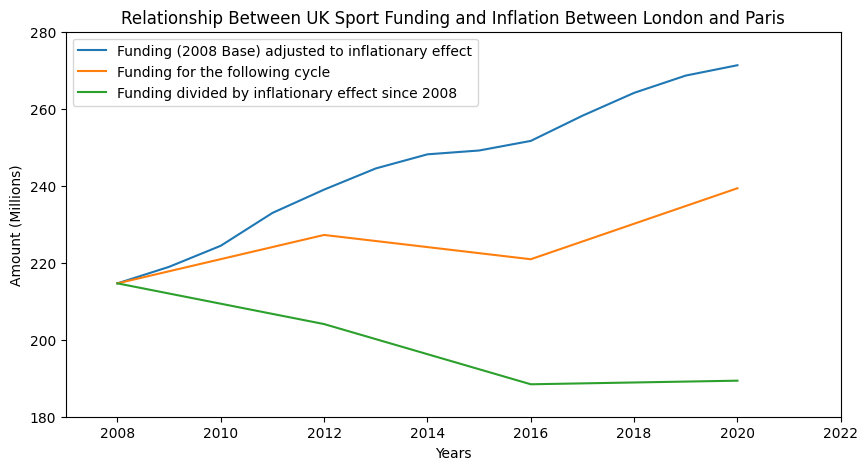

In [350]:
# funding_df
# inflation_df
# medals_df

# graph to show funding relative to inflation value
# to see if fundign has increased in line with inflation

import matplotlib.pyplot as plt


values = funding_df.iloc[34][1:5]

values = pd.to_numeric(values, errors='coerce')

values_millions = values / 1_000_000


multiplier_by_year = [] #inflation_df
funding_by_multiplier = []

for i in range(2008,2024,4):
    multiplier_by_year.append(inflation_df.loc[inflation_df['Year'] == i, 'Multiplier'].values[0])

for i in range(4):
    funding_by_multiplier.append(values_millions[i]/multiplier_by_year[i])


plt.figure(figsize=(10, 5))

plt.title('Relationship Between UK Sport Funding and Inflation Between London and Paris')
plt.xlabel('Years')
plt.ylabel('Amount (Millions)')

plt.axis([2007, 2022,180, 280])
plt.plot(inflation_df['Year'][0:13],inflation_df['Base 2008 Millions'][0:13], label = 'Funding (2008 Base) adjusted to inflationary effect')
plt.plot([2008,2012,2016,2020],values_millions.values , label = 'Funding for the following cycle')
plt.plot([2008,2012,2016,2020],funding_by_multiplier , label = 'Funding divided by inflationary effect since 2008')

plt.legend()
plt.show()






[170, 171, 150, 129]


/var/folders/py/9s8d_qcs3v9_8j3ztwpzt8640000gn/T/ipykernel_74280/4195756934.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  medal_score.append((int(medals_df.loc[i][2])*4) + (int(medals_df.loc[i][3])*2) + (int(medals_df.loc[i][4])*1))


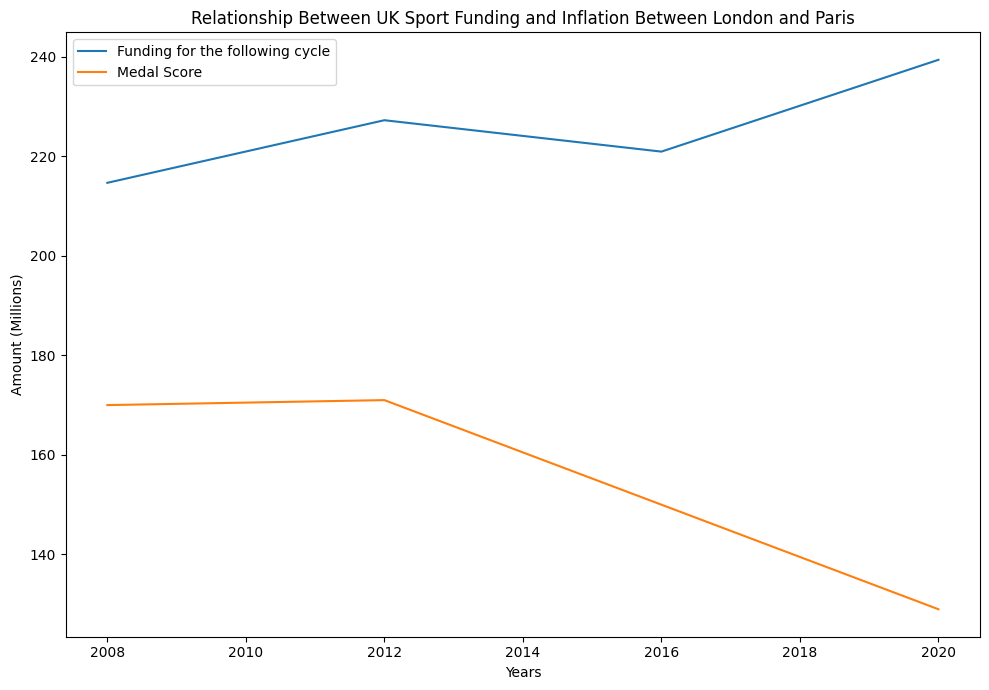

In [ ]:
medal_score = [] #gold = 4 silver = 2 bronze = 1
for i in range(26,30):
    medal_score.append((int(medals_df.loc[i][2])*4) + (int(medals_df.loc[i][3])*2) + (int(medals_df.loc[i][4])*1))

print(medal_score)

plt.figure(figsize=(10, 7))

plt.title('Relationship Between UK Sport Funding and Inflation Between London and Paris')
plt.xlabel('Years')
plt.ylabel('Amount (Millions)')
plt.plot([2008,2012,2016,2020],values_millions.values , label = 'Funding for the following cycle')
plt.plot([2008,2012,2016,2020],medal_score , label = 'Medal Score')

plt.legend()
plt.show()
